

<a target="_blank" href="https://colab.research.google.com/github/olsenlabmit/Polymer-Graph-Similarity/blob/main/notebook/Polymer_Similarity_SI_Earth_Mover_Distance_vs_Simple_Sum_or_Average_Method.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# @title Copyright & License (click to expand)
# MIT License

# Copyright (c) 2022 olsenlabmit

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# SI-I: Earth Mover’s Distance vs. Simple Sum or Average Method

This notebook is to perform the calculations and reproduce the results of **Earth Mover’s Distance vs. Simple Sum or Average Method** in the manuscript, Jiale Shi, Nathan J. Rebello, Dylan Walsh, Weizhong Zou, Michael E. Deagen, Bruno Salomao Leao, Debra J. Audus, Bradley D. Olsen, "Quantifying Pairwise Chemical Similarity for Polymers", submitted.

# Import and Install Necessary Libraries

In [2]:
# import necessary libraries available in colab
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import shutil
import sys
import os.path

# install necessary libraries not available in colab
if not shutil.which("rdkit"):
    !pip install -q rdkit

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AtomPairs import Pairs

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert shutil.which("pyomo")

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc
        except:
            pass

assert shutil.which("cbc") or os.path.isfile("cbc")

from pyomo.environ import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.11.4+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.108.6+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-2_amd64.deb .

# Similarity Score Functions

## Earth Mover's Distance (EMD) Similarity Function

Use the earth mover's distance to compute similarity for repeating units and end groups.


$ EMD (P,Q)= \min_{F}\sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j}d_{i,j}$

$ {\rm subject\ to\ } f_{i,j} \geq 0, {\rm\ for\ any\ } \ 1 \leq i \leq m, 1 \leq j \leq n $

$     \sum_{j=1}^{n}f_{i,j} =w_{pi}, {\rm for\ any} \ 1 \leq i \leq m $

$     \sum_{i=1}^{m}f_{i,j} =w_{qj}, {\rm for\ any} \ 1 \leq j \leq n $

$     \sum_{i=1}^{m}\sum_{j=1}^{n}f_{i,j} = \sum_{i}^{m} w_{pi} = \sum_{j}^{n} w_{qj} = 1 $ 


Molecular fragment ensemble $P = \{(p_1,w_{p_1}) ,(p_2,w_{p_2}),...,(p_i,w_{p_i}),...,(p_m,w_{p_m})\}$ has $m$ molecular fragments, where $p_i$ is a molecular fragment such as a repeat unit or end group and $w_{p_i}>0$ is the weight, related to the average probability (or frequency, $z$) of the molecular fragment being present in the polymer. Similarly, the second ensemble $Q = {(q_1,w_{q_1}),(q_2,w_{q_2}),...,(q_j,w_{q_j}),...,(q_n,w_{q_n})}$ has $n$ molecular fragments.  The sums of the weights for $P$ and $Q$ are both normalized and equal to one.
The distance $d_{i,j}$ is calculated by the converting the pairwise similarity score $s_{i,j}$ between $p_{i}$ and $q_{j}$, where $d_{i,j} = 1 - s_{i,j}$.
Transport flow $f_{i,j}$ represents the amount of weight at $p_i$ which is transported to $q_j$. 

The EMD linear optimization code  refers to [3.1. Transportation Networks, ND Pyomo Notebook](https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/03.01-Transportation-Networks.html)

Once $EMD (P,Q)$ is calculated, the similarity score between $P$ and $Q$ is, 

$S(P,Q) = 1- EMD (P,Q)$

In [3]:
def Similarity_Score_EMD_Calculation(
    query_smiles_list=None,
    query_smiles_weight_list=None,
    target_smiles_list=None,
    target_smiles_weight_list=None,
    embedding_function="MorganFingerprint",
    similarity_score_function="Tanimoto",
):
    # obtain the length of query smiles list and target smiles list
    query_smiles_list_length = len(query_smiles_list)

    target_smiles_list_length = len(target_smiles_list)

    # check whether the query is identical to the target
    if set(query_smiles_list) == set(target_smiles_list):
        query_smiles_array = np.array(query_smiles_list)
        query_smiles_level_array = np.array(query_smiles_weight_list)
        inds_query = query_smiles_array.argsort()
        sorted_query_smiles_array = query_smiles_array[inds_query]
        sorted_query_smiles_level_array = query_smiles_level_array[inds_query]

        target_smiles_array = np.array(target_smiles_list)
        target_smiles_level_array = np.array(target_smiles_weight_list)
        inds_target = target_smiles_array.argsort()
        sorted_target_smiles_array = target_smiles_array[inds_target]
        sorted_target_smiles_level_array = target_smiles_level_array[inds_target]

        if np.array_equal(
            sorted_query_smiles_array, sorted_target_smiles_array
        ) and np.array_equal(
            sorted_query_smiles_level_array, sorted_target_smiles_level_array
        ):
            return 1.0

        query_smiles_reduced_list = list(set(query_smiles_list))
        query_smiles_reduced_list_number = []

        for i in range(0, len(query_smiles_reduced_list)):
            query_smiles_reduced_list_number_i = 0
            for j in range(0, len(query_smiles_list)):
                if query_smiles_reduced_list[i] == query_smiles_list[j]:
                    query_smiles_reduced_list_number_i = (
                        query_smiles_reduced_list_number_i + query_smiles_weight_list[j]
                    )

            query_smiles_reduced_list_number.append(
                query_smiles_reduced_list_number_i / sum(query_smiles_weight_list)
            )

        target_smiles_reduced_list = list(set(target_smiles_list))
        target_smiles_reduced_list_number = []

        for i in range(0, len(target_smiles_reduced_list)):
            target_smiles_reduced_list_number_i = 0
            for j in range(0, len(target_smiles_list)):
                if target_smiles_reduced_list[i] == target_smiles_list[j]:
                    target_smiles_reduced_list_number_i = (
                        target_smiles_reduced_list_number_i
                        + target_smiles_weight_list[j]
                    )

            target_smiles_reduced_list_number.append(
                target_smiles_reduced_list_number_i / sum(target_smiles_weight_list)
            )

        if query_smiles_reduced_list_number == target_smiles_reduced_list_number:
            return 1.0

    # transfer SMILES to fingerprints
    if embedding_function == "RDKFingerprint":
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [Chem.RDKFingerprint(x) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [Chem.RDKFingerprint(x) for x in target_mol_list]

    elif embedding_function == "MorganFingerprint":
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [
            AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048)
            for x in query_mol_list
        ]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [
            AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048)
            for x in target_mol_list
        ]

    elif embedding_function == "MACCSkeys":
        query_mol_list = [Chem.MolFromSmiles(x) for x in query_smiles_list]
        query_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in query_mol_list]
        target_mol_list = [Chem.MolFromSmiles(x) for x in target_smiles_list]
        target_fingerprint_list = [MACCSkeys.GenMACCSKeys(x) for x in target_mol_list]

    else:
        print(
            embedding_function
            + " is not included in the current vision."
            + " Please choose an available embedding function:"
        )
        print("MorganFingerprint, RDKFingerprint, MACCSkeys.")
        return False

    # define the required three sets
    Demand = {}  # query
    Supply = {}  # target
    T = {}  # transport flow

    # define the weight for SMILES in query, w_i
    if len(set(query_smiles_weight_list)) == 1:
        for i in range(0, query_smiles_list_length):
            Demand["P" + str(i + 1)] = 1 / query_smiles_list_length

    else:
        query_weight_sum = sum(query_smiles_weight_list)
        for i in range(0, query_smiles_list_length):
            Demand["P" + str(i + 1)] = query_smiles_weight_list[i] / query_weight_sum

    # define weight for SMILES in target, w_j
    if len(set(target_smiles_weight_list)) == 1:
        for j in range(0, target_smiles_list_length):
            Supply["Q" + str(j + 1)] = 1 / target_smiles_list_length

    else:
        target_weight_sum = sum(target_smiles_weight_list)
        for j in range(0, target_smiles_list_length):
            Supply["Q" + str(j + 1)] = target_smiles_weight_list[j] / target_weight_sum

    # use similarity function to calculate d_ij
    if similarity_score_function == "Tanimoto":
        for i in range(0, query_smiles_list_length):
            for j in range(0, target_smiles_list_length):
                T[
                    ("P" + str(i + 1), "Q" + str(j + 1))
                ] = 1 - DataStructs.FingerprintSimilarity(
                    query_fingerprint_list[i], target_fingerprint_list[j]
                )

    elif similarity_score_function == "Dice":
        for i in range(0, query_smiles_list_length):
            for j in range(0, target_smiles_list_length):
                T[
                    ("P" + str(i + 1), "Q" + str(j + 1))
                ] = 1 - DataStructs.FingerprintSimilarity(
                    query_fingerprint_list[i],
                    target_fingerprint_list[j],
                    metric=DataStructs.DiceSimilarity,
                )

    elif similarity_score_function == "Cosine":
        for i in range(0, query_smiles_list_length):
            for j in range(0, target_smiles_list_length):
                T[
                    ("P" + str(i + 1), "Q" + str(j + 1))
                ] = 1 - DataStructs.FingerprintSimilarity(
                    query_fingerprint_list[i],
                    target_fingerprint_list[j],
                    metric=DataStructs.CosineSimilarity,
                )

    else:
        print(
            similarity_score_function
            + " is not included in the current vision."
            + " Please choose an available similarity function:"
        )
        print("Tanimoto, Dice, or Cosine")
        return

    # linear optimization with pyomo
    # step 0: Create an instance of the model
    model = ConcreteModel()
    model.dual = Suffix(direction=Suffix.IMPORT)

    # step 1: define index sets
    CUS = list(Demand.keys())
    SRC = list(Supply.keys())

    # step 2: define the decision
    model.x = Var(CUS, SRC, domain=NonNegativeReals)

    # step 3: define objective
    model.Cost = Objective(
        expr=sum([T[c, s] * model.x[c, s] for c in CUS for s in SRC]), sense=minimize
    )

    # step 4: define constraints
    model.src = ConstraintList()
    for s in SRC:
        model.src.add(sum([model.x[c, s] for c in CUS]) == Supply[s])

    model.dmd = ConstraintList()
    for c in CUS:
        model.dmd.add(sum([model.x[c, s] for s in SRC]) == Demand[c])

    # step 5: solve the model
    results = SolverFactory("cbc").solve(model)

    if "ok" == str(results.Solver.status):
        SimilarityScore = 1 - model.Cost()
        return SimilarityScore

    else:
        print("No Valid Solution Found")
        return False

## Topology Similarity Function

Use graph edit distance $GED(g_1, g_2)$ to compute the topological similarity $S_{\rm TOP}(g_1,g_2)$.

$GED(g_1, g_2)$  is computed via a networkx function [graph_edit_distance](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.similarity.graph_edit_distance.html), while the topological similarity score $S_{\rm TOP}(g_1,g_2)$ in the range of (0,1] is computed via a exponential decay function:


$S_{\rm TOP}(g_1, g_2) = \exp(-\frac{\alpha \cdot GED(g_1, g_2)}{(N_1 + N_2)/2})$

where $N_i$ is the number of nodes in graph $g_i$.

In [4]:
def Topology_Similarity_Score_Calculation(Graph1=None, Graph2=None, alpha=1):
    if Graph1 == None:
        print("Missing Graph1")
        return
    if Graph2 == None:
        print("Missing Graph2")
        return

    Graph1_number_nodes = Graph1.number_of_nodes()
    Graph2_number_nodes = Graph2.number_of_nodes()

    graph_edit_distance = nx.graph_edit_distance(Graph1, Graph2)

    topology_similarity_score = np.exp(
        -alpha * graph_edit_distance / ((Graph1_number_nodes + Graph2_number_nodes) / 2)
    )

    return topology_similarity_score

## Weighted Mean Function for Overall Pairwise Similarity Score $S_{\rm OA}$ 

From the above EMD and GED calculations, three similarity scores are obtained: $S_{\rm RU}$  for repeat units, $S_{\rm EG}$  for end groups, and $S_{\rm TOP}$   for topology. To calculate the overall similarity score $S_{\rm OA}$. Two weighted mean functions are provided. 

1. weighted geometric mean

$S_{\rm OA} =  S_{\rm RU}^{W_{\rm RU}} \cdot S_{\rm TOP}^{W_{\rm TOP}} \cdot S_{\rm EG}^{W_{\rm EG}} $ 

2. weighted arithmetic mean

$S_{\rm OA} =  S_{\rm RU} \cdot W_{\rm RU} + S_{\rm TOP} \cdot W_{\rm TOP} +  S_{\rm EG} \cdot W_{\rm EG} $ 


In [5]:
def Overall_Similarity_Score_Calculation(
    query=None,
    target=None,
    embedding_function="RDKFingerprint",
    similarity_score_function="Tanimoto",
    alpha=1,
    Repeat_Unit_Weight=0.475,
    Topology_Weight=0.475,
    End_Group_Weight=0.05,
    Mean_Function="geometric",
    details_print=False,
    return_with_components=False,
):
    if query == None or target == None:
        print(
            "Either query polymer or target polymer is missing! Please check the input."
        )
        return

    Repeat_Unit_Similarity_Score = Similarity_Score_EMD_Calculation(
        query_smiles_list=query.repeat_unit_smiles_list,
        query_smiles_weight_list=query.repeat_unit_smiles_weight_list,
        target_smiles_list=target.repeat_unit_smiles_list,
        target_smiles_weight_list=target.repeat_unit_smiles_weight_list,
        embedding_function=embedding_function,
        similarity_score_function=similarity_score_function,
    )

    Topology_Similarity_Score = Topology_Similarity_Score_Calculation(
        Graph1=query.graph_representation,
        Graph2=target.graph_representation,
        alpha=alpha,
    )

    if len(query.end_group_smiles_list) == 0 and len(target.end_group_smiles_list) == 0:
        End_Group_Similarity_Score = 1.0

    elif (
        len(query.end_group_smiles_list) == 0 and len(target.end_group_smiles_list) != 0
    ) or (
        len(query.end_group_smiles_list) != 0 and len(target.end_group_smiles_list) == 0
    ):
        End_Group_Similarity_Score = 1.0

    else:
        End_Group_Similarity_Score = Similarity_Score_EMD_Calculation(
            query_smiles_list=query.end_group_smiles_list,
            query_smiles_weight_list=query.end_group_smiles_weight_list,
            target_smiles_list=target.end_group_smiles_list,
            target_smiles_weight_list=target.end_group_smiles_weight_list,
            embedding_function=embedding_function,
            similarity_score_function=similarity_score_function,
        )

    # verify whether the weight sum is normalized.
    if abs(Repeat_Unit_Weight + Topology_Weight + End_Group_Weight - 1) != 0.0:
        Weight_Sum = Repeat_Unit_Weight + Topology_Weight + End_Group_Weight

        Repeat_Unit_Weight = Repeat_Unit_Weight / Weight_Sum

        Topology_Weight = Topology_Weight / Weight_Sum

        End_Group_Weight = End_Group_Weight / Weight_Sum

    if Mean_Function == "geometric":
        Overall_Similarity_Score = (
            pow(Repeat_Unit_Similarity_Score, Repeat_Unit_Weight)
            * pow(Topology_Similarity_Score, Topology_Weight)
            * pow(End_Group_Similarity_Score, End_Group_Weight)
        )

    elif Mean_Function == "arithmetic":
        Overall_Similarity_Score = (
            Repeat_Unit_Weight * Repeat_Unit_Similarity_Score
            + Topology_Weight * Topology_Similarity_Score
            + End_Group_Weight * End_Group_Similarity_Score
        )

    else:
        print(
            "Your input mean function ",
            Mean_Function,
            " is not implemented currently."
            + " Please choose those implemented mean functions, such as arithmetic, geometric",
        )
        return

    if details_print == True:
        print("Details of the Similarity Score:\n")
        print(
            "Repeat Unit Similarity Score = ",
            Repeat_Unit_Similarity_Score,
            ", Normalized Weight for Repeat Unit = ",
            Repeat_Unit_Weight,
        )
        print(
            "Topology Similarity Score = ",
            Topology_Similarity_Score,
            ", Normalized Weight for Topology = ",
            Topology_Weight,
        )
        print(
            "End Group Similarity  = ",
            End_Group_Similarity_Score,
            ", Normalized Weight for End Group = ",
            End_Group_Weight,
        )
        print(
            "Overall Pairwise Similarity Score with "
            + Mean_Function
            + " mean function = ",
            Overall_Similarity_Score,
        )
        print("\n")

    if return_with_components == True:
        return (
            Overall_Similarity_Score,
            Repeat_Unit_Similarity_Score,
            Topology_Similarity_Score,
            End_Group_Similarity_Score,
        )

    return Overall_Similarity_Score

# Define Polymer Class for Importing Polymer data

The polymer graph is decomposed into three components: repeat units, end groups and topology. 

(I) To compute $S_{\rm RU}$  for repeat units, we need the polymer's (1) repeat unit SMILES list and (2) corresponding weight list.

(II) To compute $S_{\rm EG}$  for end groups, we need the polymer's (3) end group SMILES list and (4) corresponding weight list.

(III) To compute $S_{\rm TOP}$ for topology, we need the polymers' (5) topological graph representation.

Therefore, in the Polymer Class, we have to define the above five elements which are required to perform polymer similarity calculation.

In [6]:
class Polymer:
    def __init__(
        self,
        repeat_unit_smiles_list=None,
        repeat_unit_smiles_weight_list=None,
        end_group_smiles_list=None,
        end_group_smiles_weight_list=None,
        graph_representation=None,
    ):
        if repeat_unit_smiles_list == None:
            print(
                "Error: Repeat Unit SMILES are missing."
                + " Please define the Repeat Unit SMILES."
            )
            return

        else:
            self.repeat_unit_smiles_list = repeat_unit_smiles_list

        if repeat_unit_smiles_weight_list == None:
            print(
                "Error: Repeat Unit weights are missing."
                + " Please re-enter the correct Repeat Unit weights.\n"
            )
            return

        elif len(repeat_unit_smiles_weight_list) != len(repeat_unit_smiles_list):
            print(
                "Error: Repeat Unit weights are not correct."
                + " Please re-enter the correct Repeat Unit SMILES and weights.\n"
            )
            return

        else:
            self.repeat_unit_smiles_weight_list = repeat_unit_smiles_weight_list

        if end_group_smiles_list == None and end_group_smiles_weight_list == None:
            self.end_group_smiles_list = []
            self.end_group_smiles_weight_list = []
            print(
                "Notice: The Polymer has NO End Group.\n"
                + "If this is what you want, this message is NOT Error.\n"
                + "Otherwise, please enter the correct End Group SMILES and weights.\n"
            )

        elif (
            end_group_smiles_list == None and end_group_smiles_weight_list != None
        ) or (end_group_smiles_list != None and end_group_smiles_weight_list == None):
            print(
                "Error: End Group SMILES and weights are not matching."
                + " Please re-enter the correct End Group SMILES and weights.\n"
            )
            return

        else:
            if len(end_group_smiles_list) != len(end_group_smiles_weight_list):
                print(
                    "Error: End Group SMILES and weights are not matching."
                    + " Please re-enter the correct End Group SMILES and weights.\n"
                )
                return

            else:
                if (
                    len(end_group_smiles_list) == 0
                    and len(end_group_smiles_weight_list) == 0
                ):
                    print(
                        "Notice: The Polymer has NO End Group.\n"
                        + "If this is what you want, this message is NOT Error.\n"
                        + "Otherwise, please enter the correct End Group SMILES and weights.\n"
                    )

                self.end_group_smiles_list = end_group_smiles_list
                self.end_group_smiles_weight_list = end_group_smiles_weight_list

        if graph_representation == None:
            print(
                "Error: Topology graph representation is missing."
                + " Please define the topology graph representation.\n"
            )
            return

        else:
            self.graph_representation = graph_representation

# SI: Earth Mover’s Distance vs. Simple Sum or Average Method

<img src="https://drive.google.com/uc?export=view&id=1-PQ9jBUGD9qJcdvKRk--U0YsMmRDah8r"  width="50%" height="50%">

# Define Polymers


diblock_top_graph_representation number of nodes:  8
diblock_top_graph_representation number of edges:  11


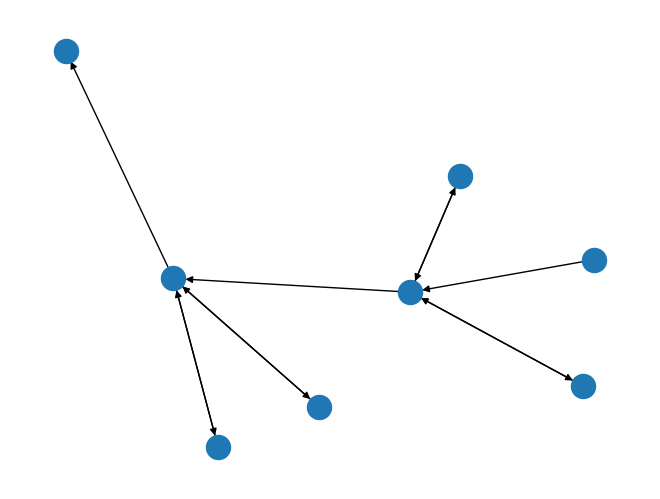

In [7]:
diblock_top_graph_representation = nx.MultiDiGraph()
diblock_top_graph_representation.add_nodes_from(
    ["E1", "D1", "D2", "E2", "R1", "R1'", "R2", "R2'"]
)
diblock_top_graph_representation.add_edges_from(
    [
        ("E1", "D1"),
        ("D1", "R1"),
        ("R1", "D1"),
        ("D1", "R1'"),
        ("R1'", "D1"),
        ("D1", "D2"),
        ("D2", "R2"),
        ("R2", "D2"),
        ("D2", "R2'"),
        ("R2'", "D2"),
        ("D2", "E2"),
    ]
)
nx.draw(diblock_top_graph_representation)
print(
    "diblock_top_graph_representation number of nodes: ",
    diblock_top_graph_representation.number_of_nodes(),
)
print(
    "diblock_top_graph_representation number of edges: ",
    diblock_top_graph_representation.number_of_edges(),
)

## Polymer X


In [8]:
Polymer_X = Polymer(
    repeat_unit_smiles_list=["*CC(*)CCCCCCC", "*CC(*)c1ccc(CCCCCCC(=O)OC)cc1"],
    repeat_unit_smiles_weight_list=[1, 1],
    end_group_smiles_list=["*C(C)(C)C#N", "*C(C)(C)C#N"],
    end_group_smiles_weight_list=[1, 1],
    graph_representation=diblock_top_graph_representation,
)

## Polymer Y


In [9]:
Polymer_Y = Polymer(
    repeat_unit_smiles_list=["*CC(*)CCCCCCCC(=O)OC", "*CC(*)c1ccc(CCCCCC)cc1"],
    repeat_unit_smiles_weight_list=[1, 1],
    end_group_smiles_list=["*C(C)(C)C#N", "*C(C)(C)C#N"],
    end_group_smiles_weight_list=[1, 1],
    graph_representation=diblock_top_graph_representation,
)

# Calculate Similarity Scores 
## Calculate the Pairwise Similarity Score between Polymer X and Polymer Y.

In [10]:
Overall_Similarity_Score_Calculation(
    query=Polymer_X,
    target=Polymer_Y,
    embedding_function="MorganFingerprint",
    similarity_score_function="Tanimoto",
    alpha=1,
    Repeat_Unit_Weight=0.475,
    Topology_Weight=0.475,
    End_Group_Weight=0.05,
    Mean_Function="geometric",
    details_print=True,
    return_with_components=False,
)

Details of the Similarity Score:

Repeat Unit Similarity Score =  0.5419354838709678 , Normalized Weight for Repeat Unit =  0.475
Topology Similarity Score =  1.0 , Normalized Weight for Topology =  0.475
End Group Similarity  =  1.0 , Normalized Weight for End Group =  0.05
Overall Pairwise Similarity Score with geometric mean function =  0.7475239373001081




0.7475239373001081

 **Repeat Unit Similarity Score with EMD =  0.5419354838709678**

# Simple Sum or Average Methods

In [11]:
SMILES_list_Polymer_X = Polymer_X.repeat_unit_smiles_list

# the locations of the 1s in sum of the fingerprints
list_Polymer_X = []

for smiles in SMILES_list_Polymer_X:
    mol = Chem.MolFromSmiles(smiles)
    smiles = Chem.MolToSmiles(mol)
    print("SMILES string: \n", smiles, "\n")
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_get_onebits = list(fp.GetOnBits())
    fp_get_onebits.sort()
    print(
        "Locations of the 1s in the fingerprints from MorganFingerprintAsBitVect(mol,2,nBits=2048) = \n",
        fp_get_onebits,
        "\n",
    )
    list_Polymer_X.extend(list(fp.GetOnBits()))

list_Polymer_X.sort()
print("Locations of the 1s in the sum of fingerprints \n", list_Polymer_X, "\n")

SMILES string: 
 *CC(*)CCCCCCC 

Locations of the 1s in the fingerprints from MorganFingerprintAsBitVect(mol,2,nBits=2048) = 
 [1, 80, 170, 226, 247, 253, 294, 591, 739, 794, 969, 1057, 1143, 1174, 1283, 1444, 1911, 1948, 1995] 

SMILES string: 
 *CC(*)c1ccc(CCCCCCC(=O)OC)cc1 

Locations of the 1s in the fingerprints from MorganFingerprintAsBitVect(mol,2,nBits=2048) = 
 [1, 14, 80, 170, 195, 226, 247, 310, 541, 650, 695, 807, 841, 969, 978, 1045, 1057, 1143, 1152, 1184, 1243, 1267, 1365, 1380, 1386, 1399, 1564, 1610, 1750, 1754, 1853, 1873, 1911, 1917, 2023, 2035] 

Locations of the 1s in the sum of fingerprints 
 [1, 1, 14, 80, 80, 170, 170, 195, 226, 226, 247, 247, 253, 294, 310, 541, 591, 650, 695, 739, 794, 807, 841, 969, 969, 978, 1045, 1057, 1057, 1143, 1143, 1152, 1174, 1184, 1243, 1267, 1283, 1365, 1380, 1386, 1399, 1444, 1564, 1610, 1750, 1754, 1853, 1873, 1911, 1911, 1917, 1948, 1995, 2023, 2035] 



In [12]:
SMILES_list_Polymer_Y = Polymer_Y.repeat_unit_smiles_list

# the locations of the 1s in the sum of fingerprints
list_Polymer_Y = []

for smiles in SMILES_list_Polymer_Y:
    mol = Chem.MolFromSmiles(smiles)
    smiles = Chem.MolToSmiles(mol)
    print("SMILES string: \n", smiles, "\n")
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_get_onebits = list(fp.GetOnBits())
    fp_get_onebits.sort()
    print(
        "Locations of the 1s in the fingerprints from MorganFingerprintAsBitVect(mol,2,nBits=2048) = \n",
        fp_get_onebits,
        "\n",
    )
    list_Polymer_Y.extend(list(fp.GetOnBits()))

list_Polymer_Y.sort()
print("Locations of the 1s in the sum of fingerprints \n", list_Polymer_Y, "\n")

SMILES string: 
 *CC(*)CCCCCCCC(=O)OC 

Locations of the 1s in the fingerprints from MorganFingerprintAsBitVect(mol,2,nBits=2048) = 
 [1, 14, 80, 170, 195, 226, 247, 253, 650, 695, 739, 807, 841, 969, 1057, 1143, 1152, 1174, 1267, 1283, 1386, 1399, 1564, 1911, 1917, 1948, 1995] 

SMILES string: 
 *CC(*)c1ccc(CCCCCC)cc1 

Locations of the 1s in the fingerprints from MorganFingerprintAsBitVect(mol,2,nBits=2048) = 
 [1, 80, 170, 226, 247, 294, 310, 541, 591, 794, 969, 978, 1045, 1057, 1143, 1184, 1243, 1365, 1380, 1444, 1610, 1750, 1754, 1853, 1873, 1911, 2023, 2035] 

Locations of the 1s in the sum of fingerprints 
 [1, 1, 14, 80, 80, 170, 170, 195, 226, 226, 247, 247, 253, 294, 310, 541, 591, 650, 695, 739, 794, 807, 841, 969, 969, 978, 1045, 1057, 1057, 1143, 1143, 1152, 1174, 1184, 1243, 1267, 1283, 1365, 1380, 1386, 1399, 1444, 1564, 1610, 1750, 1754, 1853, 1873, 1911, 1911, 1917, 1948, 1995, 2023, 2035] 



In [13]:
print(list_Polymer_Y == list_Polymer_X)

True


The sum of FP(RX1) and FP(RX2) is the same as the sum of FP(RY1) and FP(RY2) implying the two polymers are the same. Therefore, the simple sum method treats two different repeat unit ensembles as the same and fails to capture the differences.